# Collaborative filtering

In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = "data/"
device = "cuda"
seed = 42

In [3]:
df = pd.read_csv(path + "ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
movie_id = df["movieId"].values
user_id = df["userId"].values
rating = df["rating"].values.astype(np.float32)

In [5]:
def norm_index(array_id):
    id_normed = {}
    ids = 0

    for i in range(0, len(array_id)):
        val = array_id[i]

        if val not in id_normed:
            id_normed[val] = ids
            ids += 1

        array_id[i] = id_normed[val] 
    
    return id_normed, array_id

# Re-index since they are not "compact"
movie_id_normed, movie_id = norm_index(movie_id)
user_id_normed, user_id = norm_index(user_id)

In [6]:
class RatingsDataset(Dataset):
    def __init__(self, movie_id, user_id, rating):
        self.len = len(movie_id)
        self.movie_id = torch.from_numpy(movie_id).to(device)
        self.user_id = torch.from_numpy(user_id).to(device)
        self.rating = torch.from_numpy(rating).to(device)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.movie_id[idx], self.user_id[idx], self.rating[idx]

In [7]:
np.random.seed(seed)
val_size = 0.2
idx = np.arange(0, len(rating))
np.random.shuffle(idx)

val_idx = idx[0:int(val_size * len(idx))]
train_idx = idx[int(val_size * len(idx)):]

In [8]:
batch_size = 128
train_set = RatingsDataset(movie_id[train_idx], user_id[train_idx], rating[train_idx])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

val_set = RatingsDataset(movie_id[val_idx], user_id[val_idx], rating[val_idx])
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [9]:
max_rating = torch.from_numpy(np.array([np.max(rating)])).to(device)
min_rating = torch.from_numpy(np.array([np.min(rating)])).to(device)

In [10]:
class CollaborativeFiltering(nn.Module):
    def __init__(self, n_factors, n_users, n_movies):
        super().__init__()
        self.u_weight = nn.Embedding(n_users, n_factors).to(device)
        self.u_weight.weight.data.uniform_(-0.01, 0.01)
        
        self.u_bias = nn.Embedding(n_users, 1).to(device)
        self.u_bias.weight.data.uniform_(-0.01, 0.01)
        
        self.m_weight = nn.Embedding(n_movies, n_factors).to(device)
        self.m_weight.weight.data.uniform_(-0.01, 0.01)
        
        self.m_bias = nn.Embedding(n_movies, 1).to(device)
        self.m_bias.weight.data.uniform_(-0.01, 0.01)
        
    def forward(self, users, movies):
        dot = (self.u_weight(users) * self.m_weight(movies)).sum(1)
        res = dot + self.u_bias(users).squeeze() + self.m_bias(movies).squeeze()
        res = F.sigmoid(res) * (max_rating - min_rating) + min_rating
        return res

In [11]:
torch.manual_seed(seed)
n_users = len(set(user_id))
n_movies = len(set(movie_id))
n_factors = 50

lr = 5e-3
num_epochs = 10
weight_decay = 1e-3

model = CollaborativeFiltering(n_factors, n_users, n_movies).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [12]:
torch.manual_seed(seed)
for epoch in range(0, num_epochs):
    for _, (movie_i, user_i, rating_target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(user_i, movie_i)
        loss = F.mse_loss(output, rating_target)
        loss.backward()
        optimizer.step()
    
    avg_loss = 0
    for _, (movie_i, user_i, rating_target) in enumerate(val_loader):
        output = model(user_i, movie_i)
        loss = F.mse_loss(output, rating_target)
        avg_loss += loss
        
    avg_loss = round(avg_loss.item() / len(train_loader), 4)
    print("Val loss at epoch {}: {}".format(epoch+1, avg_loss))

Val loss at epoch 1: 0.2319
Val loss at epoch 2: 0.2212
Val loss at epoch 3: 0.2193
Val loss at epoch 4: 0.2188
Val loss at epoch 5: 0.2189
Val loss at epoch 6: 0.2181
Val loss at epoch 7: 0.2186
Val loss at epoch 8: 0.2186
Val loss at epoch 9: 0.2186
Val loss at epoch 10: 0.2185


# Interpret the weights and biases

In [13]:
title_df = pd.read_csv(path + "movies.csv")
title_df = title_df.drop("genres", axis=1)

In [14]:
movie_bias = np.empty((len(movie_id_normed)))
movie_weight = np.empty((len(movie_id_normed), n_factors))

for i in range(0, len(movie_id_normed)):
    movie_bias[i] = model.m_bias(torch.tensor(i).to(device))
    movie_weight[i,:] = model.m_weight(torch.tensor(i).to(device)).cpu().detach().numpy()

In [15]:
para_df = pd.DataFrame(list(movie_id_normed.items()), columns=['movieId', 'normed_movie_id'])
para_df["bias_term"] = movie_bias
para_df["movie_weight"] = list(movie_weight)

In [16]:
para_df = para_df.merge(title_df, on="movieId", how="left")

## Bias term

In [17]:
# Movies with the highest bias, i.e. "best" movies
para_df.nlargest(10, "bias_term")

,movieId,normed_movie_id,bias_term,movie_weight,title
99,318,99,1.111238,"[0.0008903664420358837, -0.0004544592811726033...","Shawshank Redemption, The (1994)"
157,858,157,1.058641,"[-0.006363724358379841, 0.011272558942437172, ...","Godfather, The (1972)"
24,50,24,0.969860,"[-0.0005005205748602748, -0.01407613605260849,...","Usual Suspects, The (1995)"
505,608,505,0.945217,"[0.006409912370145321, 0.004564662463963032, -...",Fargo (1996)
79,527,79,0.942209,"[0.013021156191825867, -0.004423568956553936, ...",Schindler's List (1993)
49,296,49,0.870398,"[0.015826953575015068, 0.014967365190386772, 0...",Pulp Fiction (1994)
143,260,143,0.861996,"[0.0016738389385864139, 0.002397971460595727, ...",Star Wars: Episode IV - A New Hope (1977)
402,2571,402,0.844239,"[-0.011732501909136772, -0.005173804238438606,...","Matrix, The (1999)"
328,1221,328,0.835373,"[0.03697846829891205, 0.03600098565220833, -0....","Godfather: Part II, The (1974)"
179,1196,179,0.813694,"[-0.002828778699040413, -0.012762429192662239,...",Star Wars: Episode V - The Empire Strikes Back...


In [18]:
# Movies with the lowest bias, i.e. "worst" movies
para_df.nsmallest(10, "bias_term")

,movieId,normed_movie_id,bias_term,movie_weight,title
3075,3593,3075,-0.545033,"[0.0004187992599327117, 0.0006527402438223362,...",Battlefield Earth (2000)
944,2701,944,-0.534859,"[0.003784086788073182, 0.0019237141823396087, ...",Wild Wild West (1999)
822,1562,822,-0.526352,"[0.03424863517284393, 0.03360817953944206, -0....",Batman & Robin (1997)
530,1499,530,-0.480430,"[-0.013129714876413345, 0.034658148884773254, ...",Anaconda (1997)
670,160,670,-0.463632,"[-0.002971842186525464, 0.0031293691135942936,...",Congo (1995)
821,1556,821,-0.444498,"[0.00044561413233168423, 0.0018554840935394168...",Speed 2: Cruise Control (1997)
679,193,679,-0.407377,"[-2.009757372434251e-05, -0.000917826080694794...",Showgirls (1995)
2645,2642,2645,-0.407026,"[0.0029019005596637726, 0.00840141624212265, 0...",Superman III (1983)
641,2720,641,-0.397068,"[-0.0007677634712308645, -0.002858137246221304...",Inspector Gadget (1999)
3130,2381,3130,-0.391947,"[-0.022097963839769363, -0.036238282918930054,...",Police Academy 4: Citizens on Patrol (1987)


## Weight term

In [19]:
# Choosing the 100 most "popular" since they are more "known"
sampled_df = para_df.nlargest(100, "bias_term")

weight_array = sampled_df[["movie_weight"]].values
weight_array = np.vstack(weight_array[i][0] for i in range(0, len(weight_array)))

In [20]:
tsne = TSNE(n_components=2)
tsne_array = tsne.fit_transform(weight_array)

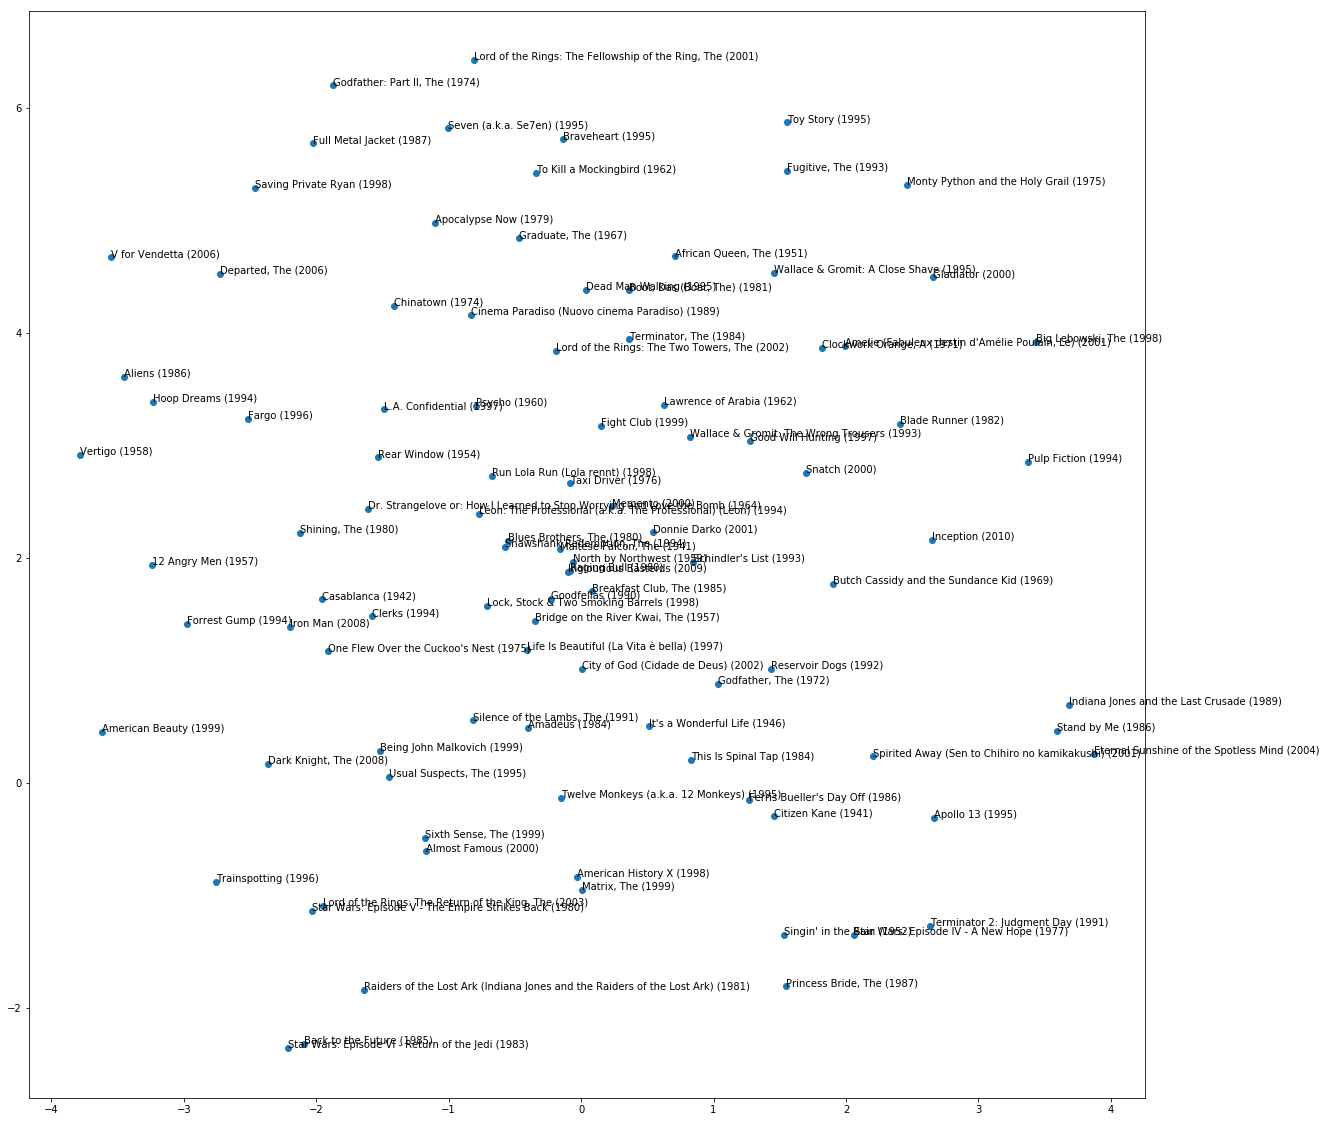

In [21]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(tsne_array[:,0], tsne_array[:,1])

for i, txt in enumerate(sampled_df["title"].values):
    ax.annotate(txt, (tsne_array[i,0], tsne_array[i,1]))
plt.show()